In [35]:
%matplotlib inline
import numpy as np
import pandas as pd
from numpy import pi
import matplotlib.pyplot as plt
from fractions import Fraction
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram, plot_bloch_multivector
# Loading your IBM Q account(s)
provider = IBMQ.load_account()

/opt/conda/lib/python3.7/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '
ibmqfactory.load_account:WARNING:2020-11-30 20:18:26,228: Credentials are already in use. The existing account in the session will be replaced.


# Shor's Algorithm
Shor's algorithm for $N$ qubits can be realized with the example from Qiskit Textbook https://qiskit.org/textbook/ch-algorithms/shor.html. The code needs to implement quantum phase estimation on the unitary operator:
$$ U|y\rangle \equiv |ay \bmod N \rangle $$
The period we are interested in is the number of applications of this operator that gives out the same state as what we started with. For period $r$ this is:
$$ U^r|y\rangle = |y \rangle $$

Let us implement this for $a=3$, $N=10$. The complete Shor's circuit consists of the following parts:
<ol>
<li> 
  Initialize a register of $n$ counting qubits in state $|+ \rangle$.
</li>
<li> 
  Initialize a register of $m$ ancilla qubits in state $|1 \rangle$.
</li>
<li> 
  Apply controlled $U$-gates to the counting register.
</li>
<li> 
  Apply inverse Quantum Fourier Transform to the counting register.
</li>
<li> 
  Measure the counting register.
</li>
</ol>
From exercise 4-2 we already have the Quantum Frourier Transform function and its inverse, we shall also use U1 and U2 from: https://github.com/msilaev/qiskit/blob/master/HW4-hint.ipynb.

In [4]:
n=3
m=4
a=3
N=10

def qft(n):
    qc = QuantumCircuit(n)
    # Apply Hadamard and CROT-gates
    for m in range(n):
        j=n-m-1
        qc.h(j)
        for qubit in range(j):
            qc.cu1(pi/2**(j-qubit), qubit, j)
    # Swap the qubit indices
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    qc.name = " QFT"
    return qc

def inverse_qft(n):
    qft_circuit = qft(n)
    invqft_circuit = qft_circuit.inverse()
    invqft_circuit.name = " INV_QFT"
    return invqft_circuit


def U2():
    """Controlled multiplication by 9 mod 10"""
    U = QuantumCircuit(4)   
    U.x(3)
    U = U.to_gate()
    U.name = "U2" 
    c_U = U.control()
    return c_U

def U1():
    """Controlled multiplication by 9 mod 10"""
    U = QuantumCircuit(4)   
    U.x(1)
    U.swap(3,2)
    U = U.to_gate()
    U.name = "U1" 
    c_U = U.control()
    return c_U

Now to put the Shor's circuit together.

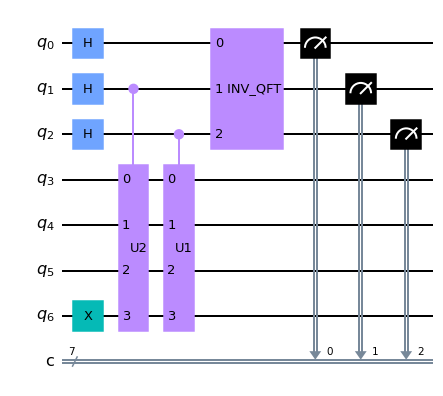

In [22]:
# Initialize n qubits for the counting register and m qubits for the ancilliary register.
qc = QuantumCircuit(n + m, n+m)
for q in range(n):
    qc.h(q)
qc.x(n+m-1)

# Apply controlled U-gates to the counting register.
qc.append(U2(), [q-1] + [i+n for i in range(m)])
qc.append(U1(), [q] + [i+n for i in range(m)])

# Apply inverse QFT to the counting register.
qc.append(inverse_qft(n), range(n))

# Measure circuit
qc.measure(range(n), range(n))
qc.draw()

## Testing with Simulator

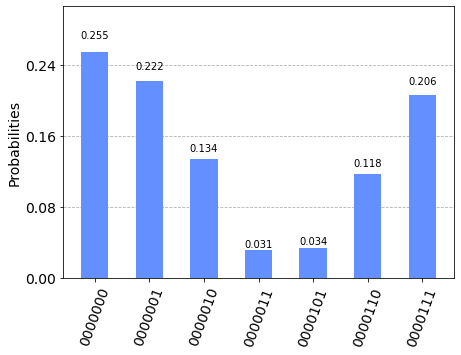

In [23]:
backend = Aer.get_backend('qasm_simulator')
results = execute(qc, backend, shots=2048).result()
counts = results.get_counts()
plot_histogram(counts)

Now we can take the binary results, convert back to decimal and find the corresponding eigenvalues.

In [31]:
# From: https://qiskit.org/textbook/ch-algorithms/shor.html
rows, measured_phases = [], []
for output in counts:
    decimal = int(output, 2)  # Convert (base 2) string to decimal
    phase = decimal/(2**n) # Find corresponding eigenvalue
    measured_phases.append(phase)
    # Add these values to the rows in our table:
    rows.append(["%s(bin) = %i(dec)" % (output, decimal), 
                 "%i/%i = %.2f" % (decimal, 2**n, phase)])
# Print the rows in a table
headers=["Register Output", "Phase"]
df = pd.DataFrame(rows, columns=headers)
print(df)

         Register Output       Phase
0  0000000(bin) = 0(dec)  0/8 = 0.00
1  0000001(bin) = 1(dec)  1/8 = 0.12
2  0000010(bin) = 2(dec)  2/8 = 0.25
3  0000011(bin) = 3(dec)  3/8 = 0.38
4  0000101(bin) = 5(dec)  5/8 = 0.62
5  0000110(bin) = 6(dec)  6/8 = 0.75
6  0000111(bin) = 7(dec)  7/8 = 0.88


Simplify the phases into fractions, the denominator then gives us the period of the function we were after. 

In [33]:
# From: https://qiskit.org/textbook/ch-algorithms/shor.html
rows = []
for phase in measured_phases:
    frac = Fraction(phase).limit_denominator(15)
    rows.append([phase, "%i/%i" % (frac.numerator, frac.denominator), frac.denominator])
# Print as a table
headers=["Phase", "Fraction", "Guess for r"]
df = pd.DataFrame(rows, columns=headers)
print(df)

   Phase Fraction  Guess for r
0  0.000      0/1            1
1  0.125      1/8            8
2  0.250      1/4            4
3  0.375      3/8            8
4  0.625      5/8            8
5  0.750      3/4            4
6  0.875      7/8            8


The non-trivial period $r$ for our controlled exponentiation with $N=10$ and $a=3$ comes out as 4 or 8. We can check this is correct by graphing the out the actual function.

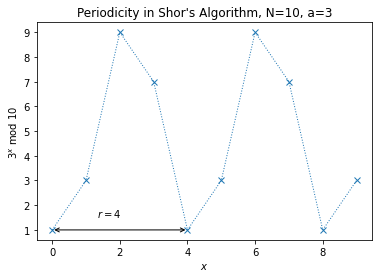

In [39]:
#From: https://github.com/msilaev/qiskit/blob/master/HW4-hint.ipynb
N = 10
a = 3

# Calculate the plotting data
xvals = np.arange(10)
yvals = [np.mod(a**x, N) for x in xvals]

# Use matplotlib to display it nicely
fig, ax = plt.subplots()
ax.plot(xvals, yvals, linewidth=1, linestyle='dotted', marker='x')
ax.set(xlabel='$x$', ylabel='$%i^x$ mod $%i$' % (a, N),
       title="Periodicity in Shor's Algorithm, N=10, a=3")
try: # plot r on the graph
    r = yvals[1:].index(1) +1 
    plt.annotate(text='', xy=(0,1), xytext=(r,1), arrowprops=dict(arrowstyle='<->'))
    plt.annotate(text='$r=%i$' % r, xy=(r/3,1.5))
except:
    print('Could not find period, check a < N and have no common factors.')